# Setup and General Data Overview

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
raw_data = pd.read_csv('data/liked_labeled.csv')

In [3]:
labeled_songs = raw_data.copy()
labeled_songs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4296 entries, 0 to 4295
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            4296 non-null   int64  
 1   Track URI             4296 non-null   object 
 2   Track Name            4296 non-null   object 
 3   Artist URI(s)         4296 non-null   object 
 4   Artist Name(s)        4296 non-null   object 
 5   Album URI             4296 non-null   object 
 6   Album Name            4296 non-null   object 
 7   Album Artist URI(s)   4296 non-null   object 
 8   Album Artist Name(s)  4296 non-null   object 
 9   Album Release Date    4296 non-null   object 
 10  Album Image URL       4296 non-null   object 
 11  Disc Number           4296 non-null   int64  
 12  Track Number          4296 non-null   int64  
 13  Track Duration (ms)   4296 non-null   int64  
 14  Track Preview URL     3247 non-null   object 
 15  Explicit             

In [4]:
labeled_songs.describe()

,Unnamed: 0,Disc Number,Track Number,Track Duration (ms),Popularity,Added By,Danceability,Energy,Key,Loudness,Mode,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo,Time Signature
count,4296.000000,4296.000000,4296.000000,4.296000e+03,4296.000000,0.0,4293.000000,4293.000000,4293.000000,4293.000000,4293.000000,4293.000000,4293.000000,4293.000000,4293.000000,4293.000000,4293.000000,4293.000000
mean,2147.500000,1.032588,6.540503,2.423103e+05,31.929004,NaN,0.563541,0.533308,5.220825,-10.394896,0.612625,0.103522,0.374874,0.323438,0.192953,0.387757,117.886939,3.894712
std,1240.292707,0.321318,6.242312,2.894246e+05,23.515855,NaN,0.185046,0.247769,3.635817,6.086908,0.487207,0.122246,0.344682,0.383817,0.163539,0.249579,30.341885,0.472055
min,0.000000,1.000000,1.000000,4.800000e+03,0.000000,NaN,0.000000,0.000098,0.000000,-46.829000,0.000000,0.000000,0.000002,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1073.750000,1.000000,2.000000,1.648762e+05,7.000000,NaN,0.453000,0.360000,2.000000,-12.582000,0.000000,0.037200,0.047200,0.000082,0.098500,0.175000,93.919000,4.000000
50%,2147.500000,1.000000,5.000000,2.148260e+05,34.000000,NaN,0.584000,0.550000,5.000000,-8.774000,1.000000,0.050900,0.274000,0.047200,0.121000,0.363000,117.964000,4.000000
75%,3221.250000,1.000000,9.000000,2.657785e+05,51.000000,NaN,0.694000,0.729000,8.000000,-6.421000,1.000000,0.105000,0.703000,0.781000,0.229000,0.573000,137.941000,4.000000
max,4295.000000,11.000000,42.000000,9.146416e+06,96.000000,NaN,0.980000,0.993000,11.000000,-0.394000,1.000000,0.928000,0.996000,0.991000,0.985000,0.982000,214.131000,5.000000


# Some basic analysis out of curiosity

In [5]:
analysis_data = labeled_songs.copy()

In [6]:
from collections import defaultdict
artists = defaultdict(int)
for i,song in analysis_data.iterrows():
	for musician in song['Artist Name(s)'].split(','):
		artists[musician] += 1

artists = pd.DataFrame(artists.items(), columns=['Artist', 'Track Count']).sort_values('Track Count', ascending=False).reset_index(drop=True)

print("Number of unique artists: " + str(len(analysis_data['Artist Name(s)'].unique())))

Number of unique artists: 1588


Text(0.5, 1.0, 'Top 50 Artists by Number of Tracks Saved')

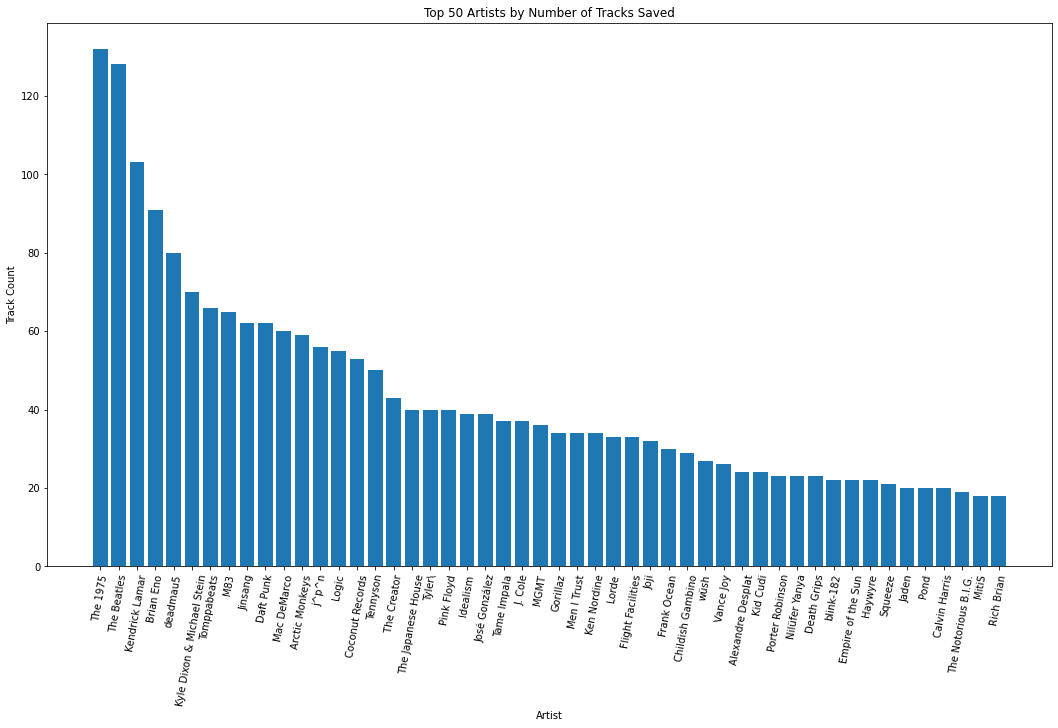

In [7]:
plt.figure(figsize=(18, 10))
plt.bar(artists['Artist'][:50], artists['Track Count'][:50])
plt.xticks(rotation=80)
plt.xlabel(artists.columns[0])
plt.ylabel(artists.columns[1])
plt.title('Top 50 Artists by Number of Tracks Saved')

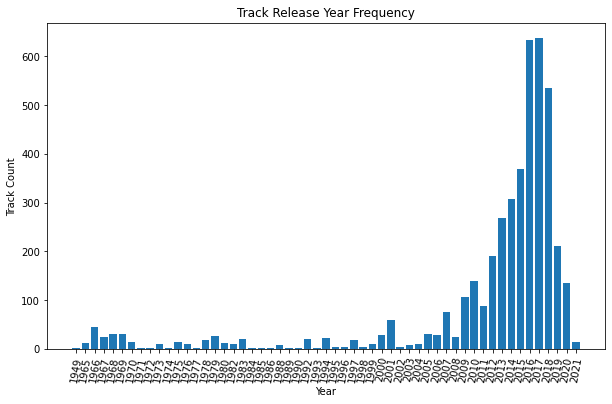

In [8]:
years = defaultdict(int)
for i,song in analysis_data.iterrows():
    years[song['Album Release Date'][:4]] += 1

years = pd.DataFrame(years.items(), columns=['Year', 'Track Count']).sort_values('Year')

plt.figure(figsize=(10, 6))
plt.bar(years['Year'], years['Track Count'])
plt.xticks(rotation=80)
plt.xlabel(years.columns[0])
plt.ylabel(years.columns[1])
plt.title('Track Release Year Frequency');

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


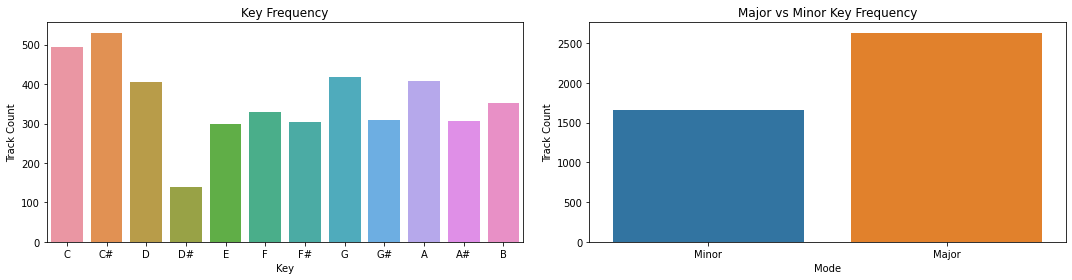

In [9]:
import seaborn as sns

plt.figure(figsize=(15,4))

plt.subplot(1, 2, 1)
axes = sns.countplot(analysis_data['Key'])
axes.set(xticklabels=['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B'])
plt.ylabel('Track Count')
plt.title('Key Frequency')

plt.subplot(1, 2, 2)
axes = sns.countplot(analysis_data['Mode'])
axes.set(xticklabels=['Minor', 'Major'])
plt.ylabel('Track Count')
plt.title('Major vs Minor Key Frequency');

plt.tight_layout(w_pad=2)

# Removing Irrelevant Features From Dataset

In [10]:
features = ['Explicit', 
            'Popularity', 
            'Danceability', 
            'Energy', 
            'Key', 
            'Loudness', 
            'Mode', 
            'Speechiness', 
            'Acousticness', 
            'Instrumentalness', 
            'Liveness', 
            'Valence', 
            'Tempo', 
            'Time Signature',
            'Label']
labels = ['Label']

In [11]:
labeled_songs = labeled_songs[features]

In [12]:
labeled_songs['Key'] = labeled_songs['Key'].astype("category")
labeled_songs['Explicit'] = labeled_songs['Explicit'].astype("category")
labeled_songs['Mode'] = labeled_songs['Mode'].astype("category")

In [13]:
labeled_songs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4296 entries, 0 to 4295
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   Explicit          4296 non-null   category
 1   Popularity        4296 non-null   int64   
 2   Danceability      4293 non-null   float64 
 3   Energy            4293 non-null   float64 
 4   Key               4293 non-null   category
 5   Loudness          4293 non-null   float64 
 6   Mode              4293 non-null   category
 7   Speechiness       4293 non-null   float64 
 8   Acousticness      4293 non-null   float64 
 9   Instrumentalness  4293 non-null   float64 
 10  Liveness          4293 non-null   float64 
 11  Valence           4293 non-null   float64 
 12  Tempo             4293 non-null   float64 
 13  Time Signature    4293 non-null   float64 
 14  Label             4296 non-null   bool    
dtypes: bool(1), category(3), float64(10), int64(1)
memory usage: 386.7 KB


In [14]:
labeled_songs['Explicit'].value_counts()

False    3567
True      729
Name: Explicit, dtype: int64

In [15]:
labeled_songs['Key'].value_counts()

1.0     530
0.0     495
7.0     417
9.0     407
2.0     405
11.0    352
5.0     329
8.0     309
10.0    306
6.0     305
4.0     298
3.0     140
Name: Key, dtype: int64

In [16]:
labeled_songs['Mode'].value_counts()

1.0    2630
0.0    1663
Name: Mode, dtype: int64

In [17]:
# Checking for imbalance in the dataset
labeled_songs['Label'].value_counts(True)

False    0.513035
True     0.486965
Name: Label, dtype: float64

In [18]:
for col in labeled_songs.columns:
    print(col, ":", labeled_songs[col].isnull().sum())

Explicit : 0
Popularity : 0
Danceability : 3
Energy : 3
Key : 3
Loudness : 3
Mode : 3
Speechiness : 3
Acousticness : 3
Instrumentalness : 3
Liveness : 3
Valence : 3
Tempo : 3
Time Signature : 3
Label : 0


In [19]:
labeled_songs[labeled_songs['Danceability'].isna()]

,Explicit,Popularity,Danceability,Energy,Key,Loudness,Mode,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo,Time Signature,Label
491,False,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
703,False,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2067,False,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False


In [20]:
# Drop rows that contain any null values
labeled_songs.dropna(inplace = True)

In [21]:
# Ensuring all features were fixed
for col in labeled_songs.columns:
    print(col, ":", labeled_songs[col].isnull().sum())

Explicit : 0
Popularity : 0
Danceability : 0
Energy : 0
Key : 0
Loudness : 0
Mode : 0
Speechiness : 0
Acousticness : 0
Instrumentalness : 0
Liveness : 0
Valence : 0
Tempo : 0
Time Signature : 0
Label : 0


In [22]:
# Replacing any NaN values with median
for col in labeled_songs.columns:
    if labeled_songs[col].isnull().sum() > 0 == True and labeled_songs[col].dtypes not in ['bool', 'category'] == True:
        labeled_songs[col] = labeled_songs[col].fillna(labeled_songs[col].median())

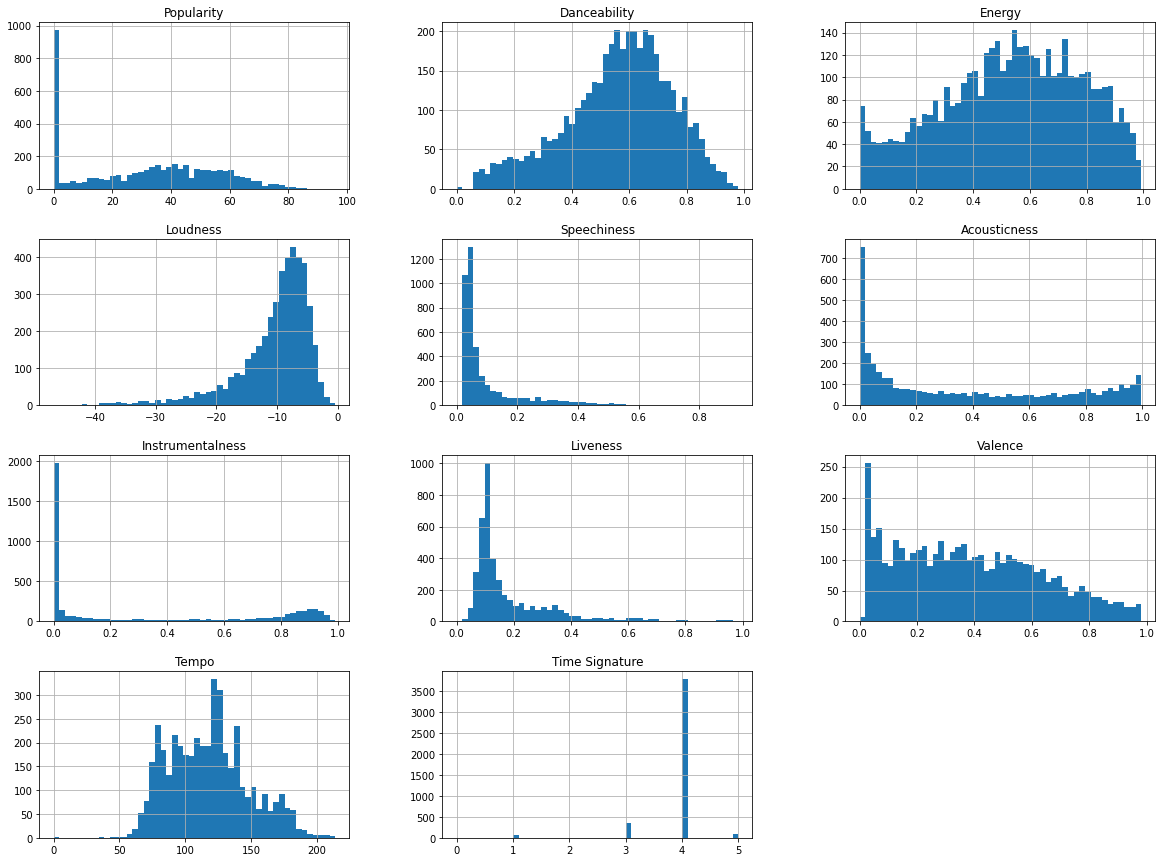

In [23]:
import matplotlib.pyplot as plt

labeled_songs.hist(bins = 50, figsize = (20,15))
plt.show()

In [24]:
cmatrix = labeled_songs.corr()
cmatrix["Label"].sort_values(ascending = False)

Label               1.000000
Popularity          0.188560
Loudness            0.024206
Tempo               0.024164
Danceability        0.024129
Time Signature      0.023851
Energy              0.014470
Acousticness       -0.008568
Valence            -0.013575
Liveness           -0.044454
Instrumentalness   -0.076210
Speechiness        -0.095719
Name: Label, dtype: float64

# Conventional Classification Approach

In [25]:
from sklearn.model_selection import train_test_split

ds_features = labeled_songs[features[:-1]]
ds_labels = labeled_songs['Label']

train_X, validation_X, train_Y, validation_Y  = train_test_split(ds_features,ds_labels,test_size = 0.20, random_state = 42)

In [26]:
from sklearn.tree import DecisionTreeClassifier

dt_model = DecisionTreeClassifier(max_depth = 5)
dt_model.fit(train_X, train_Y)

dt_model.score(validation_X, validation_Y)*100

59.25494761350407

In [27]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(max_depth = 5, n_estimators = 100)
rf_model.fit(train_X, train_Y)

rf_model.score(validation_X, validation_Y) * 100

61.35040745052387

# Neural Network Approach
In order to this we must tranform the labels into their 0 and 1 counterparts to fit the Binary classification specifications.

In [28]:
nn_train_X = train_X.copy()
nn_validation_X = validation_X.copy()

nn_train_Y = train_Y.copy()
nn_train_Y[nn_train_Y[:] == True] = 1.0

nn_validation_Y = validation_Y.copy()
nn_validation_Y[nn_validation_Y[:] == True] = 1.0

In [29]:
# integer encoding for categorical variables
for col in nn_train_X.columns:
    if nn_train_X[col].dtypes.name == 'category':
        nn_train_X[col] = nn_train_X[col].astype("float64")

for col in nn_validation_X.columns:
    if nn_validation_X[col].dtypes.name == 'category':
        nn_validation_X[col] = nn_validation_X[col].astype("float64")

In [30]:
nn_validation_X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 859 entries, 3533 to 1730
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Explicit          859 non-null    float64
 1   Popularity        859 non-null    int64  
 2   Danceability      859 non-null    float64
 3   Energy            859 non-null    float64
 4   Key               859 non-null    float64
 5   Loudness          859 non-null    float64
 6   Mode              859 non-null    float64
 7   Speechiness       859 non-null    float64
 8   Acousticness      859 non-null    float64
 9   Instrumentalness  859 non-null    float64
 10  Liveness          859 non-null    float64
 11  Valence           859 non-null    float64
 12  Tempo             859 non-null    float64
 13  Time Signature    859 non-null    float64
dtypes: float64(13), int64(1)
memory usage: 100.7 KB


In [31]:
nn_validation_X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 859 entries, 3533 to 1730
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Explicit          859 non-null    float64
 1   Popularity        859 non-null    int64  
 2   Danceability      859 non-null    float64
 3   Energy            859 non-null    float64
 4   Key               859 non-null    float64
 5   Loudness          859 non-null    float64
 6   Mode              859 non-null    float64
 7   Speechiness       859 non-null    float64
 8   Acousticness      859 non-null    float64
 9   Instrumentalness  859 non-null    float64
 10  Liveness          859 non-null    float64
 11  Valence           859 non-null    float64
 12  Tempo             859 non-null    float64
 13  Time Signature    859 non-null    float64
dtypes: float64(13), int64(1)
memory usage: 100.7 KB


In [32]:
# Normalizing data
nn_train_X -= nn_train_X.mean(axis = 0)
nn_train_X /= nn_train_X.std(axis = 0)

In [33]:
nn_validation_X -= nn_validation_X.mean(axis = 0)
nn_validation_X /= nn_validation_X.std(axis = 0)

In [34]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

nn_model = Sequential()
nn_model.add(Dense(8, input_dim = len(ds_features.columns), activation = 'relu'))
nn_model.add(Dense(4, activation = 'relu'))
nn_model.add(Dense(2, activation = 'relu'))
nn_model.add(Dense(1, activation = 'tanh'))

nn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 120       
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 36        
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 10        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 3         
Total params: 169
Trainable params: 169
Non-trainable params: 0
_________________________________________________________________


In [35]:
# Compiling the neural network
nn_model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [36]:
# Ensuring the the GPU is being used while training
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [37]:
# Training model
with tf.device('/CPU:0'):
  nn_model.fit(nn_train_X, nn_train_Y, epochs = 1000, verbose = True, validation_data = (nn_validation_X, nn_validation_Y))

- val_accuracy: 0.5949
Epoch 866/1000
108/108 [==============================] - 0s 809us/step - loss: 0.6243 - accuracy: 0.6273 - val_loss: 0.7185 - val_accuracy: 0.6019
Epoch 867/1000
108/108 [==============================] - 0s 840us/step - loss: 0.6241 - accuracy: 0.6319 - val_loss: 0.7162 - val_accuracy: 0.6030
Epoch 868/1000
108/108 [==============================] - 0s 809us/step - loss: 0.6243 - accuracy: 0.6313 - val_loss: 0.7324 - val_accuracy: 0.6054
Epoch 869/1000
108/108 [==============================] - 0s 852us/step - loss: 0.6243 - accuracy: 0.6325 - val_loss: 0.7194 - val_accuracy: 0.6042
Epoch 870/1000
108/108 [==============================] - 0s 837us/step - loss: 0.6240 - accuracy: 0.6302 - val_loss: 0.7169 - val_accuracy: 0.6054
Epoch 871/1000
108/108 [==============================] - 0s 827us/step - loss: 0.6236 - accuracy: 0.6322 - val_loss: 0.7186 - val_accuracy: 0.6007
Epoch 872/1000
108/108 [==============================] - 0s 809us/step - loss: 0.6238 - 

In [38]:
# Evaluating the neural network
nn_predictions = nn_model.predict(nn_validation_X).round()

In [39]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

acc_score = accuracy_score(nn_validation_Y, nn_predictions)
acc_score

0.5797438882421421

In [40]:
prec_score = precision_score(nn_validation_Y, nn_predictions)
prec_score

ValueError: Target is multiclass but average='binary'. Please choose another average setting, one of [None, 'micro', 'macro', 'weighted'].

In [41]:
rec_score = recall_score(nn_validation_Y, nn_predictions)
rec_score

ValueError: Target is multiclass but average='binary'. Please choose another average setting, one of [None, 'micro', 'macro', 'weighted'].

In [39]:
f1 = f1_score(nn_validation_Y, nn_predictions)
f1

0.5695876288659795

# Convolutional Neural Network Approach (SuperTML)

In [42]:
# Copying datasets over to be manipulated
cnn_train_X = nn_train_X.copy()
cnn_train_Y = nn_train_Y.copy()

cnn_valid_X = nn_validation_X.copy()
cnn_valid_Y = nn_validation_Y.copy()

In [43]:
!fc-list

s,Grassetto,ボールド,볼드체,Vet,Fet,Negrito,Жирный,粗体,عريض,Negrita
/System/Library/AssetsV2/com_apple_MobileAsset_Font6/ec2979c8550757993101e27b30b2b89cb45917fc.asset/AssetData/Yuanti.ttc: Yuanti TC,圓體\-繁,圆体\-繁:style=Light,細體,细体
/System/Library/Fonts/Avenir Next.ttc: Avenir Next,Avenir Next Heavy:style=Heavy,Regular
/System/Library/AssetsV2/com_apple_MobileAsset_Font6/a5578564cd8cb162d7ba1544317ef3ae407bf939.asset/AssetData/Klee.ttc: Klee,クレー,Klee Medium,クレー ミディアム:style=Medium,ミディアム,Regular
/System/Library/Fonts/NotoSansOriya.ttc: Noto Sans Oriya:style=Regular
/System/Library/Fonts/SFNS.ttf: Systemskrift,Systemschrift,Γραμματοσειρά συστήματος,Järjestelmäfontti,Police système,גופן מערכת,Rendszerbetűtípus,Font di sistema,システムフォント,시스템 서체,Systeemlettertype,Systemfont,Czcionka systemowa,Fonte do Sistema,Font de sistem,Системный шрифт,Font sustava,Systémové písmo,Systemtypsnitt,แบบอักษรระบบ,Sistem Fontu,Font Sistem,Системний шрифт,Phông chữ Hệ thống,系统字体,Tipo de letra do sistema,خط النظام,Tipo de l

In [44]:
from PIL import Image, ImageDraw, ImageFont

def imageEncode(data):
    images = []
    font = ImageFont.truetype("Arial.ttf", size = 27)
    location = [(25, 20), (100, 20), (175, 20), 
                (25, 70), (100, 70), (175, 70), 
                (25, 120), (100, 120), (175, 120), 
                (25, 170), (100, 170),(175, 170),
                (50, 215), (150, 215)]

    # Going through each row
    for row in data.iterrows():
        # Generate base image
        bg = np.array([[0 for _ in range(255)] for _ in range(255)], dtype = 'uint8')
        image = Image.fromarray(bg)
        draw = ImageDraw.Draw(image)

        # Adding each feature to the image
        l = 0
        for col in range(0, len(data.columns)):
          value = round(row[1][col], 2)
          draw.text(location[l], str(value), fill = 'white', font = font)
          l += 1
        
        rgb = [np.array(image, dtype='uint8') for _ in range(3)]
        images.append(rgb)

    images = np.array(images) / 255

    # move to channels last format
    images = np.moveaxis(images, 1, -1)

    return images

    # images = np.array(images) / 255
    # return np.reshape(images, (len(images), 255, 255, 3))

In [45]:
temp_set = imageEncode(cnn_train_X.sample(1))

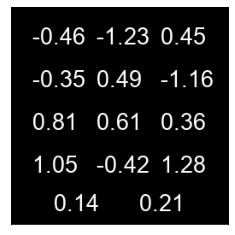

In [46]:
plt.figure()
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(temp_set[0])

In [47]:
cnn_train_X = imageEncode(cnn_train_X)
cnn_valid_X = imageEncode(cnn_valid_X)

In [48]:
print(cnn_train_X.shape)
print(cnn_valid_X.shape)

(3434, 255, 255, 3)
(859, 255, 255, 3)


In [49]:
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import Input, Dropout, Flatten, Conv2D, MaxPooling2D, Dense, Activation
    
cnn_model = Sequential()
cnn_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(255, 255, 3)))
cnn_model.add(MaxPooling2D((2, 2)))
cnn_model.add(Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(MaxPooling2D((2, 2)))
cnn_model.add(Conv2D(64, (3, 3), activation='relu'))

cnn_model.add(Flatten())
cnn_model.add(Dense(64, activation='relu'))
cnn_model.add(Dense(10))

cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 253, 253, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 126, 126, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 124, 124, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 64)        36928     
_________________________________________________________________
flatten (Flatten)            (None, 230400)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)               

In [50]:
cnn_model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [52]:
cnn_model.fit(cnn_train_X, cnn_train_Y, epochs = 1, verbose = True)

Error: Pip module Unable to parse debugpy output, please log an issue with https://github.com/microsoft/vscode-jupyter is required for debugging cells. You will need to install it to debug cells.